In [ ]:
!pip install torch_lr_finder

# Import libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Dataset

In [ ]:
# Normalize the data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Split dataset

In [ ]:
# Define path to train and test directories
dir = '/content/drive/MyDrive/Maruthi/term_project/data'

# Split data into train and test sets
# Split data into train and test sets
trainset = torchvision.datasets.CIFAR10(root= dir, train=True, download=True, transform=transform_train )
testset = torchvision.datasets.CIFAR10(root= dir, train=False, download=True, transform=transform_test)  #set train False as test set used for testing

100%|██████████| 170498071/170498071 [00:13<00:00, 12384009.84it/s]


Extracting /content/drive/MyDrive/Maruthi/term_project/data/cifar-10-python.tar.gz to /content/drive/MyDrive/Maruthi/term_project/data
Files already downloaded and verified


## Dataloaders

In [ ]:
# Define batch size
batch_size = 256

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Classes

In [ ]:
# Define classes (10 classes)
classes = ('plane',
           'car',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')

# ResNet18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
num_class = model.fc.in_features
model.fc = nn.Linear(num_class, 10) #Last layer is modified for 10 classes

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=5.59E-04)

In [ ]:
#Loss function
criterion=nn.CrossEntropyLoss()

In [ ]:
# # Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs):
     for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = trainloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = testloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the accuracies
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print('-'*30)
     return model

In [ ]:
# Train the model
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
train Loss: 0.7969 Acc: 0.7200
val Loss: 0.3682 Acc: 0.8754
------------------------------
Epoch 2/20
train Loss: 0.5917 Acc: 0.7933
val Loss: 0.3880 Acc: 0.8731
------------------------------
Epoch 3/20
train Loss: 0.5299 Acc: 0.8145
val Loss: 0.2872 Acc: 0.9015
------------------------------
Epoch 4/20
train Loss: 0.4901 Acc: 0.8283
val Loss: 0.2583 Acc: 0.9142
------------------------------
Epoch 5/20
train Loss: 0.4584 Acc: 0.8412
val Loss: 0.2862 Acc: 0.9046
------------------------------
Epoch 6/20
train Loss: 0.4367 Acc: 0.8494
val Loss: 0.2630 Acc: 0.9132
------------------------------
Epoch 7/20
train Loss: 0.4178 Acc: 0.8536
val Loss: 0.2552 Acc: 0.9132
------------------------------
Epoch 8/20
train Loss: 0.3367 Acc: 0.8837
val Loss: 0.1623 Acc: 0.9451
------------------------------
Epoch 9/20
train Loss: 0.3008 Acc: 0.8953
val Loss: 0.1558 Acc: 0.9486
------------------------------
Epoch 10/20
train Loss: 0.2842 Acc: 0.9033
val Loss: 0.1524 Acc: 0.9486
----------

In [ ]:
# Save the trained model
torch.save(model.state_dict(),'/content/drive/MyDrive/Maruthi/term_project/resnet18')

In [ ]:
model.eval()

def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy on test set
test_accuracy = calculate_accuracy(testloader, model)
print(f'Accuracy of the network on the test images: {test_accuracy:.2f}%')

Accuracy of the network on the test images: 95.40%


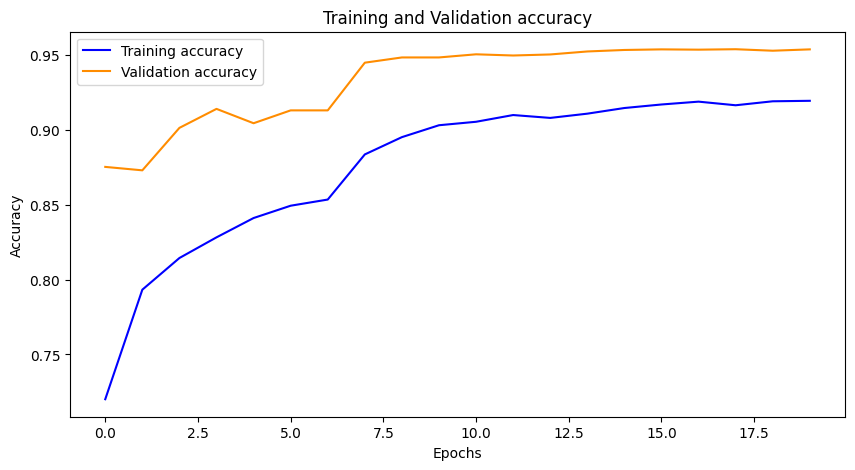

In [ ]:
#Plot train and val accuracies
if isinstance(train_acc_history[0], torch.Tensor):
    train_acc_history = [x.cpu().numpy() for x in train_acc_history]
if isinstance(val_acc_history[0], torch.Tensor):
    val_acc_history = [x.cpu().numpy() for x in val_acc_history]

epochs =range( len(train_acc_history))
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc_history, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc_history, 'darkorange', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

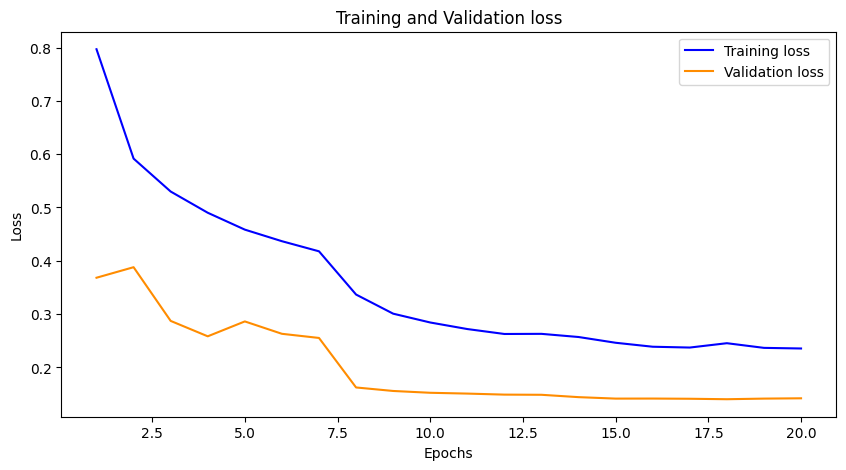

In [ ]:
#Plot train and val losses
if isinstance(train_loss_history[0], torch.Tensor):
    train_loss_history = [x.cpu().numpy() for x in train_loss_history]
if isinstance(val_loss_history[0], torch.Tensor):
    val_loss_history = [x.cpu().numpy() for x in val_loss_history]
epochs = range(1, len(train_loss_history) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss_history, 'blue', label='Training loss')
plt.plot(epochs, val_loss_history, 'darkorange', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


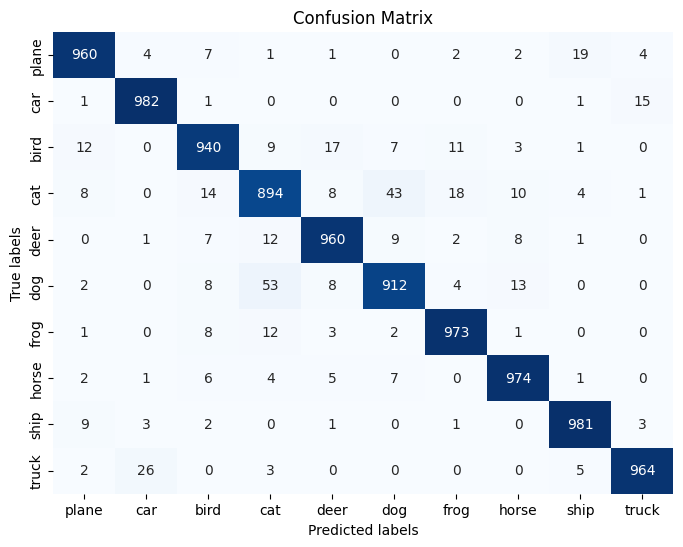

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False, xticklabels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], yticklabels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Predict
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert outputs to probabilities
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

# Get the top 5 categories predicted by the model
_, top5_cat_ids = torch.topk(probabilities, 5)
top5_prob = probabilities[top5_cat_ids]

# Print the predictions
for idx, prob in zip(top5_cat_ids, top5_prob):
    print(f"Category ID: {idx.item()}, Probability: {prob.item()}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Category ID: 7, Probability: 0.9999946355819702
Category ID: 5, Probability: 5.420275556389242e-06
Category ID: 4, Probability: 3.498828249348662e-08
Category ID: 3, Probability: 9.32822974419878e-09
Category ID: 2, Probability: 6.615054615188853e-10


In [ ]:
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(trainloader, start_lr=1e-7, end_lr=1, num_iter=100)
lr_finder.plot()
lr_finder.reset()